#Importing Libraries

In [4]:
import os
from numpy.random import seed
#pip install opencv-python
import cv2 #open cv 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage 
from skimage.io import imread,imshow
from skimage import io,color
from skimage.color import rgb2gray,gray2rgb
from skimage.transform import  resize, rescale
from sklearn.metrics import mean_squared_error
from sklearn import datasets, metrics, model_selection,preprocessing
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay,roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.applications import VGG16, VGG19, resnet50 ,ResNet152
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten,  BatchNormalization
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,BatchNormalization ,Activation
from keras.utils.vis_utils import plot_model
import sklearn
# Keras specific
import keras
from keras.models import Sequential
from keras.layers import Dense
from math import sqrt
import random
!pip install facenet_pytorch
from facenet_pytorch import MTCNN
from PIL import Image

#Helper Functions

In [ ]:
# Plotting the Confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the five classes
class_names = ["angry","happy","neutral", "sad", "surprise"]

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

In [ ]:
# def reset_graph(seed=41):
#     tf.compat.v1.reset_default_graph()
#     tf.random.set_seed(seed)
#     np.random.seed(seed) 

In [ ]:
def plot_loss_history(history):

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

In [ ]:
def plot_accuracy_history(history):

  k = ''
  if 'accuracy' in history.history :
      k = 'accuracy'    

  if 'acc' in history.history :
      k = 'acc'
      
  if k != '' :    
      plt.plot(history.history[k])
      plt.plot(history.history['val_'+k])
      plt.title('Model Accuracy')
      plt.ylabel('Accuracy')
      plt.xlabel('Epoch')
      plt.legend(['train', 'validation'], loc='upper left')
      plt.show()

#Loading and Preprocessing the Images

---

**Mounting to google drive**

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**This function is used to extract faces using MTCNN model imported from PyTorch**

In [8]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(92,112)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = asarray(image)
    # create the detector, using default weights and specify device as cuda to speed up detection
    detector = MTCNN( device='cuda')
    # detect faces in the image
    results = detector.detect(pixels)
    # print("RESULTS : " , results)
    # extract the bounding box from the first face
    if any(x is None for x in results ):
      return  "No face is detected" #since MTCNN sometimes fails to extract the dataset, then an error 
    x1, y1, width, height = results[0][0]
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[int(y1):int(y2), int(x1):int(x2)]
    # resize pixels for the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

**This function loops over images in a directory and create 2 empty list: one to hold the images and another one to assign the corresponding label to them 
After reading and labelling each image, the face is extracted by "extract_faces function.**

In [10]:
def load_images(imgs_path):
  all_images=[]
  all_labels=[]
  labels=["angry","happy","neutral","sad","surprise"]
  x=0
  for i in range(5):
      path=imgs_path[i]
      print(path)
      for file in os.listdir(path):
        y=extract_face(os.path.join(path,file))
        print("Image Number : " + str(x))
        if y != "No face is detected":
          all_images.append(y)
          all_labels.append(labels[i])
        x+=1
  return np.array(all_images),np.array(all_labels)

**Reading the path of the directory from the drive**

In [ ]:
path_train="/content/drive/MyDrive/AN_Dataset/train/"
imgs_path_training=[path_train+"angry/",path_train+ "happy/",path_train+ "neutral/",path_train+ "sad/",path_train+ "surprise/"]

path_valid="/content/drive/MyDrive/AN_Dataset/validation/"
imgs_path_validation=[path_valid+"angry/",path_valid+ "happy/",path_valid+ "neutral/",path_valid+ "sad/",path_valid+ "surprise/"]

path_test="/content/drive/MyDrive/AN_Dataset/test/"
imgs_path_testing=[path_test+"angry/",path_test+ "happy/",path_test+ "neutral/",path_test+ "sad/",path_test+ "surprise/"]

In [ ]:
train_images,train_labels=load_images(imgs_path_training)
valid_images,valid_labels=load_images(imgs_path_validation)
test_images,test_labels=load_images(imgs_path_testing)

#Saving images as NPZ files

---

**Since Loading images takes a considerable time and Collab GPU resources often fails, so we saved images as npz to facilitate reading them**

In [ ]:
X_train=np.array(train_images)
print("size of the training images",train_images.shape)
y_train=np.array(train_labels)
print("Count training labels", np.unique(train_labels,return_counts=True))

x = open('X_train.npy', 'wb')
np.savez_compressed(x, X_train)

X = open('y_train.npy', 'wb')
np.savez_compressed(X, y_train)

In [ ]:
X_valid=np.array(valid_images)
print("size of the validating images",valid_images.shape)
y_valid=np.array(valid_labels)
print("Count validating labels",np.unique(valid_labels,return_counts=True))
v = open('X_valid.npy', 'wb')
np.savez_compressed(v, X_valid)

V= open('y_valid.npy', 'wb')
np.savez_compressed(V, y_valid)

In [ ]:
X_test=np.array(test_images)
print("size of the testing images",test_images.shape)
y_test=np.array(test_labels)
print("Count testing labels",np.unique(test_labels,return_counts=True))

t = open('X_test.npy', 'wb')
np.savez_compressed(t, X_test)

T = open('y_test.npy', 'wb')
np.savez_compressed(T, y_test)

#Loading NPZ files

In [ ]:
def load_dataset(PathOfSavedData):
  X_train = np.load(PathOfSavedData+'X_train1.npy', mmap_mode='r')
  y_train = np.load(PathOfSavedData+'y_train1.npy', mmap_mode='r')
  X_valid = np.load(PathOfSavedData+'X_valid1.npy', mmap_mode='r')
  y_valid = np.load(PathOfSavedData+'y_valid1.npy', mmap_mode='r')
  X_test = np.load(PathOfSavedData+'X_test1.npy', mmap_mode='r')
  y_test = np.load(PathOfSavedData+'y_test1.npy', mmap_mode='r')
  ,
  X_train=X_train['arr_0']
  y_train=y_train['arr_0']
  X_valid=X_valid['arr_0']
  y_valid=y_valid['arr_0']
  X_test=X_test['arr_0']
  y_test=y_test['arr_0']
  
  return (X_train,y_train,X_valid,y_valid,X_test,y_test)

In [25]:
X_train,y_train,X_valid,y_valid,X_test,y_test= load_dataset("/content/drive/MyDrive/EmotionDataset/")

In [26]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((46546, 92, 112), (46546,), (6691, 92, 112), (6691,), (818, 92, 112), (818,))

In [30]:
#VGG19, needs the input images to be rgb
X_test_new=[]
for i in range(len(X_test)):
  X_test_new.append(gray2rgb(X_test[i]))

  X_train_new=[]
for i in range(len(X_train)):
  X_train_new.append(gray2rgb(X_train[i]))

  X_valid_new=[]
for i in range(len(X_valid)):
  X_valid_new.append(gray2rgb(X_valid[i]))

the image label is: happy
shape (92, 112, 3)


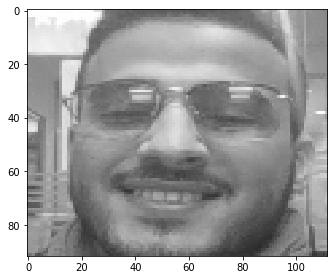

In [31]:
imshow(X_train_new[800])        #displaying the image of index 800 and it's label 
print("the image label is:", y_train[800] ) 
print("shape", X_train_new[800].shape)

the image label is: surprise
shape (92, 112, 3)


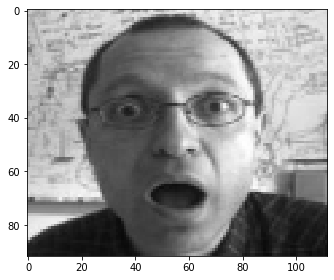

In [32]:
imshow(X_valid_new[1200])        #displaying the image of index 1200 and it's label 
print("the image label is:", y_valid[1200] ) 
print("shape", X_valid_new[1200].shape)

the image label is: angry
shape (92, 112, 3)


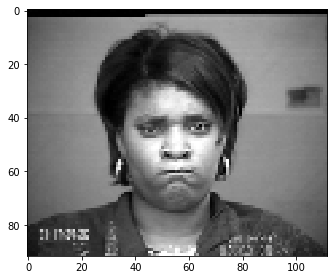

In [33]:
imshow(X_test_new[30])        #displaying the image of index 30 and it's label 
print("the image label is:", y_test[30] ) 
print("shape", X_test_new[30].shape)

In [37]:
#mapping categorical labels and then apply hot Encoding 
mapping = {"angry":0, "happy":1,"neutral":2, "sad":3, "surprise":4}
y_train_class = np.array([mapping[key] for key in y_train])
y_valid_class = np.array([mapping[key] for key in y_valid])
y_test_class = np.array([mapping[key] for key in y_test])

nClasses = 5
# Use Keras' handy utils
y_train_k = tensorflow.keras.utils.to_categorical(y_train_class, num_classes=nClasses)
y_valid_k = tensorflow.keras.utils.to_categorical(y_valid_class, num_classes=nClasses)
y_test_k = tensorflow.keras.utils.to_categorical(y_test_class, num_classes=nClasses)

# Transfer Learning VGG19
Freezing the first 10 layers and adding 4 convolution layes

In [5]:
import tensorflow
seed(110)
tensorflow.random.set_seed(110)

from tensorflow.keras.applications import VGG19
 
vgg_model_CLASS = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(92,112,3))

for layer in vgg_model_CLASS.layers:
    layer.trainable = False

# reset_graph(seed=9)

# last layers output
y = vgg_model_CLASS.layers[10].output

# Block 3

y = Conv2D(512, (3,3) ,padding='same')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = MaxPooling2D((2, 2), strides=(2, 2))(y)

# Block 4
y = Conv2D(256, (3, 3), activation='relu', padding='same')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = MaxPooling2D((2, 2), strides=(2, 2))(y)

# Block 5
y = Conv2D(64, (3,3), activation='relu', padding='same')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = MaxPooling2D((2, 2), strides=(2, 2))(y)

# Block 5
y = Conv2D(16, (3, 3), activation='relu', padding='same')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = MaxPooling2D((2, 2), strides=(2, 2))(y)

y = Flatten(name='flatten')(y)
y = Dense(10, activation='relu',kernel_regularizer='l2' )(y)
y = Dropout(0.4)(y)
y = Dense(5,activation='softmax' ,kernel_regularizer='l2')(y)

from tensorflow.keras.models import Model
vgg_model_classification = Model(inputs=vgg_model_CLASS.input, outputs=y)   #85 validation %

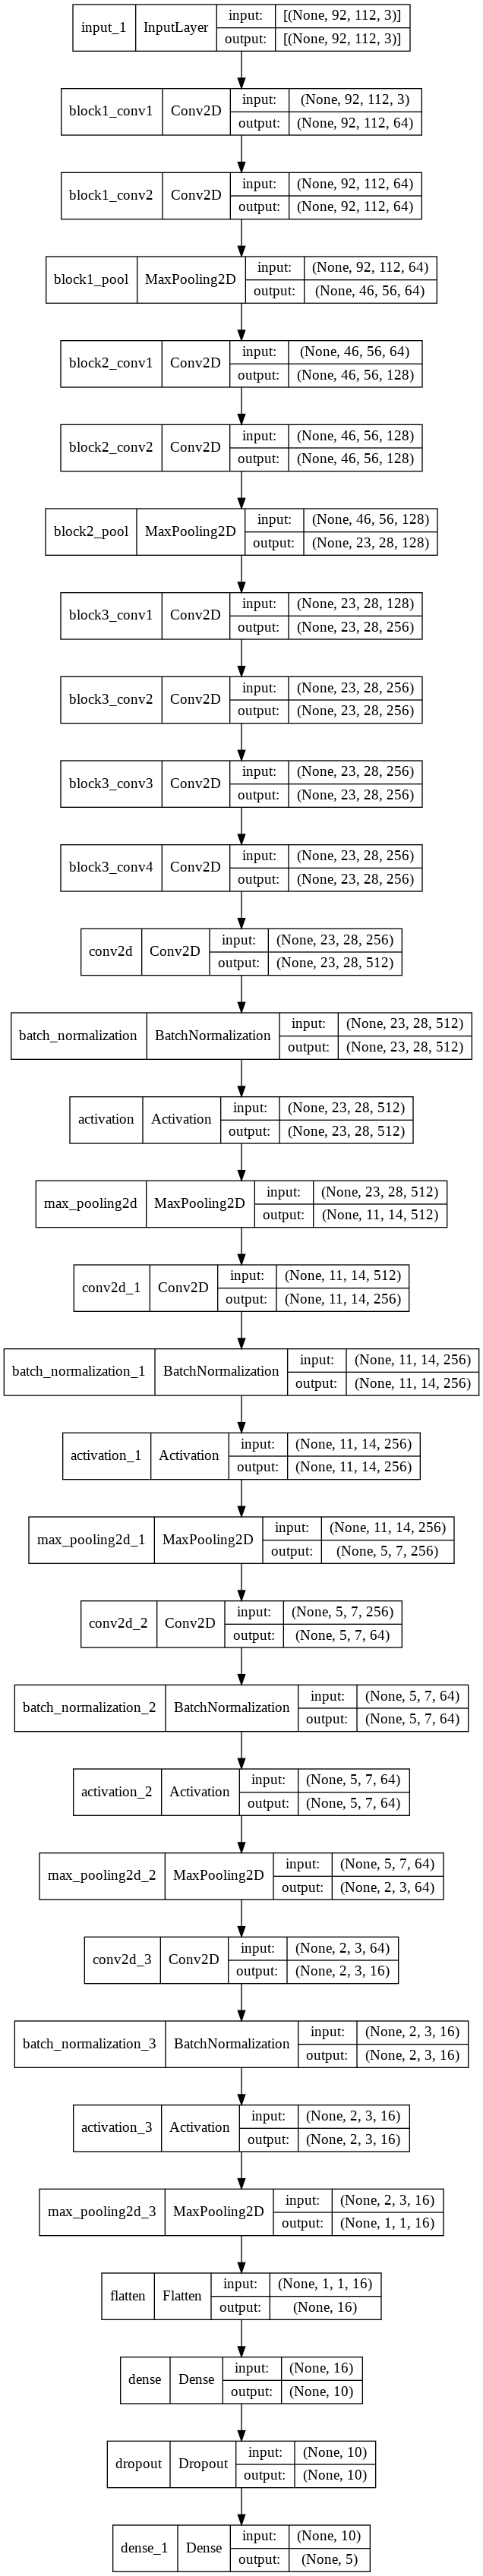

In [6]:
# print(vgg_model_classification.summary())
plot_model(vgg_model_classification, to_file='VGG19.png', show_shapes=True, show_layer_names=True)

#Model Training

In [24]:
seed(110)
tensorflow.random.set_seed(110)

# callback = tf.keras.callbacks.EarlyStopping(monitor='loss',mode='min',patience=3)
# reset_graph(seed=9)

vgg_model_classification.compile(loss='categorical_crossentropy', 
                           optimizer='Adam', 
                           metrics=['accuracy'])

history_classification = vgg_model_classification.fit(np.array(X_train_new), y_train_k, batch_size=32, epochs=10, verbose=1, validation_data=(np.array(X_valid_new), y_valid_k),shuffle=True)

Epoch 1/15
1455/1455 [==============================] - 191s 130ms/step - loss: 0.9718 - accuracy: 0.6348 - val_loss: 0.6694 - val_accuracy: 0.7918
Epoch 2/15
1455/1455 [==============================] - 188s 129ms/step - loss: 0.6915 - accuracy: 0.7583 - val_loss: 0.7842 - val_accuracy: 0.7305
Epoch 3/15
1455/1455 [==============================] - 184s 126ms/step - loss: 0.6195 - accuracy: 0.7836 - val_loss: 0.5092 - val_accuracy: 0.8464
Epoch 4/15
1455/1455 [==============================] - 184s 127ms/step - loss: 0.5758 - accuracy: 0.7996 - val_loss: 0.5021 - val_accuracy: 0.8492
Epoch 5/15
1455/1455 [==============================] - 184s 126ms/step - loss: 0.5428 - accuracy: 0.8118 - val_loss: 0.5216 - val_accuracy: 0.8449
Epoch 6/15
1455/1455 [==============================] - 184s 126ms/step - loss: 0.4989 - accuracy: 0.8299 - val_loss: 0.4727 - val_accuracy: 0.8552
Epoch 7/15
1455/1455 [==============================] - 184s 126ms/step - loss: 0.4588 - accuracy: 0.8442 - val_

In [ ]:
#training
classification_trainpredict_prob = vgg_model_classification.predict(X_train_new)
clasification_train_pred = classification_trainpredict_prob.argmax(axis=-1)
#validation
classification_validpredict_prob = vgg_model_classification.predict(X_valid_new)
clasification_valid_pred = classification_validpredict_prob.argmax(axis=-1)
#testing
classification_testpredict_prob = vgg_model_classification.predict(np.array(X_test_new))
clasification_test_pred = classification_testpredict_prob.argmax(axis=-1)

#Evaluation Metrics

---

Models are evaluated by Precision, Recall and F1 score, In addition to plotting the Confusion matrix

**Classification Report**

In [ ]:
target = {"angry","happy","neutral", "sad", "surprise"}

In [ ]:
print("Classification Report of Training data:\n\n",classification_report(y_train_class,clasification_train_pred , target_names=target))

Classification Report of Training data:

               precision    recall  f1-score   support

         sad       0.96      0.99      0.98      5790
       happy       1.00      0.98      0.99      5943
     neutral       0.95      0.98      0.97      5985
       angry       0.98      0.94      0.96      5191
    surprise       0.99      0.99      0.99      6262

    accuracy                           0.98     29171
   macro avg       0.98      0.98      0.98     29171
weighted avg       0.98      0.98      0.98     29171



In [ ]:
print("Classification Report of Validation data:\n\n",classification_report(y_valid_class,clasification_valid_pred , target_names=target))

In [ ]:
print("Classification Report of testing data:\n\n",classification_report(y_test_class,clasification_test_pred , target_names=target))

Classification Report of testing data:

               precision    recall  f1-score   support

         sad       0.20      0.31      0.24        45
     neutral       0.69      0.78      0.73        69
       happy       0.92      0.64      0.76       593
       angry       0.11      0.50      0.19        28
    surprise       0.55      0.87      0.67        83

    accuracy                           0.66       818
   macro avg       0.49      0.62      0.52       818
weighted avg       0.80      0.66      0.70       818



**Confusion Matrix**

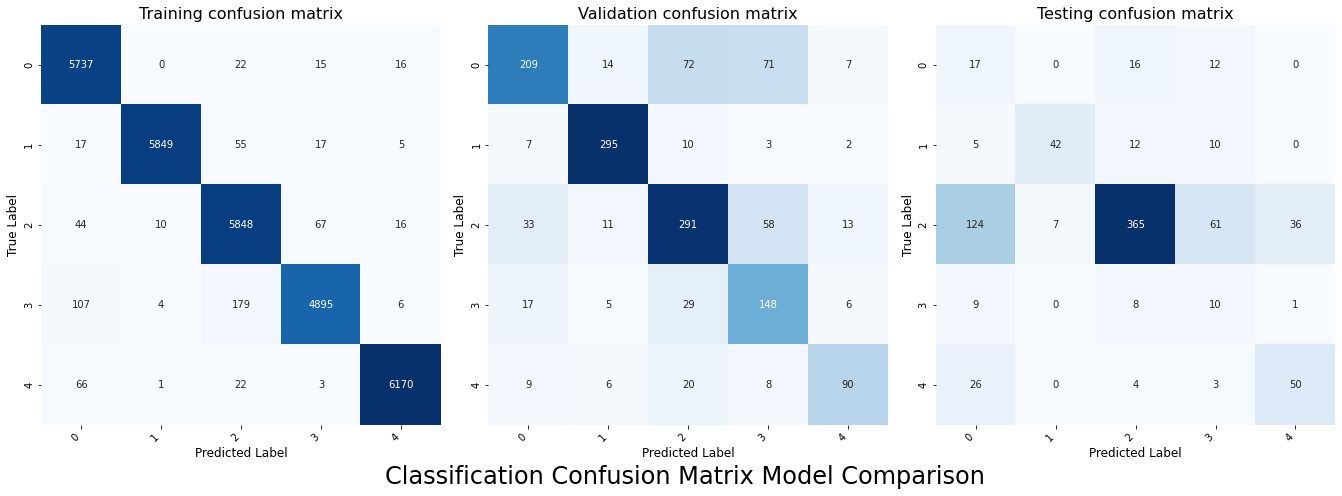

In [ ]:
fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20, 5))

plot_heatmap(y_train_class,clasification_train_pred,[0,1,2,3,4], ax1, title="Training confusion matrix")  
plot_heatmap(y_valid_class,clasification_valid_pred,[0,1,2,3,4], ax2, title="Validation confusion matrix")    
plot_heatmap(y_test_class,clasification_test_pred,[0,1,2,3,4], ax3, title="Testing confusion matrix")   

fig.suptitle("Classification Confusion Matrix Model Comparison", fontsize=24)
fig. tight_layout(pad=7.0)
fig.subplots_adjust(top=3.00)
plt.show()

**Training Visualization**

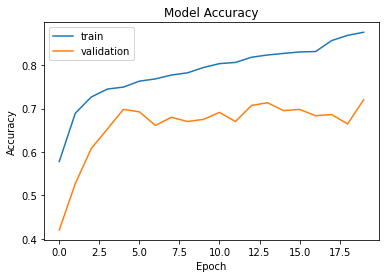

In [ ]:
plot_accuracy_history(history_classification)

**Loss**

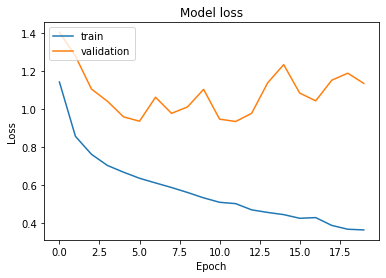

In [ ]:
plot_loss_history(history_classification)

#Converting saved model from keras to Tensor Flow lite

In [ ]:
#Saving with Keras
vgg_model_classification.save("vgg19_model.h5")

In [ ]:
load_model = load_model("vgg19_model.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(load_model) # path to the SavedModel directory

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16] #to speed up the inference
tflite_model = converter.convert()
with open('Final_Emotion_Model.tflite', 'wb') as f:
  f.write(tflite_model)